In [2]:


from Lab28_session_header import *

from uncertainties import ufloat
import uncertainties as unc

from get_data_from_hdf5 import get_data

# Please update these path varibles to your local machine.
env_session_file_location = r"\\172.24.54.234\\NAS-Lab28\\Data"
NAS_Path = r"\\172.24.54.234\\NAS-Lab28"
Plot_path= r"\\172.24.54.234\\NAS-Lab28\\Users\\Bane\\Plots"

#Bg database
bgdb=pd.read_csv(NAS_Path+"\\DataBases\\bg_db.csv")
#make blank dataframe for background subtraction debugging

blankBG_DF= pd.DataFrame({"Avg Anode":[0]*50000})


# Session Analysis

## Build Run list from new database

In [3]:
Connection = sqlite3.connect(NAS_Path+"\\Data\\lab_28_run.db")
RunDatabase = pd.read_sql("SELECT * from runs", Connection).sort_values(by='run', ascending=False)
Connection.close()


In [4]:
RunDatabase

,run,old_run_name,session,date,configuration,grid,run_type,cathode_V,cathode_V_err,cathode_grid_V,...,drift_length_mm_err,run_notes,extraction_length_mm,extraction_length_mm_err,collection_length_mm,collection_length_mm_err,cathode_preamp_gain,cathode_preamp_gain_err,anode_preamp_gain,anode_preamp_gain_err
1121,1122,20250530-00927,43,250530,152,2.0,production,1351.40,0.5,1320.0,...,0.07,Drift field sweep pumping,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1120,1121,20250530-00925,43,250530,152,2.0,production,20.27,0.5,1980.0,...,0.07,Drift field sweep anode off 924 while pumping,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1119,1120,20250530-00926,43,250530,152,2.0,production,1351.40,0.5,1320.0,...,0.07,Drift field sweep anode off 927 while pumping,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1118,1119,20250530-00924,43,250530,152,2.0,production,2027.00,0.5,1980.0,...,0.07,Drift field sweep while pumping,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
1117,1118,20250530-00923,43,250530,152,2.0,production,1689.20,0.5,1650.0,...,0.07,Drift field sweep while pumping,1.57,0.01,1.57,0.010,0.770,0.060,0.657,0.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,5,20240517-13100037,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001
3,4,20240517-13100036,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001
2,3,20240517-13100035,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001
1,2,20240517-13100034,1,240517,None,NaN,None,NaN,NaN,NaN,...,0.08,None,0.00,0.00,0.51,0.006,0.656,0.001,0.708,0.001


In [5]:

def Get_Waveform_from_session(run_number: int):
    """
    Get_Waveform_from_session(run_number: int) -> dict
    This function takes a run number and returns a dictionary of the waveforms from the session file."""
    RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]
    session_file_name= f"{env_session_file_location}\\\{RunInfo['session']:03}_{RunInfo['date']}.h5"
    run_dict={}
    with h5py.File(session_file_name, 'r') as session_h5:
        keys = list(session_h5["run"][str(run_number)].keys())
        for  key in keys:
            run_dict[key] = session_h5['run'][str(run_number)][key][:]
    return run_dict    

def GetBGRun(run):
    global bgdb
    try:
        return bgdb.query("run==%i"%(run)).iloc[0]["background"]
    except:
        return -1

def get_session_filename(run_number: int) -> str:
    """
    get_session_filename(run_number: int) -> str
    This function takes a run number and returns the session file name."""
    RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]
    session_file_name= f"{env_session_file_location}\\\{RunInfo['session']:03}_{RunInfo['date']}.h5"
    return session_file_name

In [6]:
def GetSinBG(x_data,y_data,time_start=0,time_stop=10,stepsize=100,debug=10,plot=True):
    
    x_fit=[]
    y_fit=[]
    
    if np.mean(y_data)*1000 <= 0.001:
        print("issue with weird data")
        return [0,0,0,0,0],[0,0,0,0,0]

    if len(x_data) <=1 or len(y_data)<=1 or len(x_data) != len(y_data):

        print("X and Y need to be equal in length and need two more data points")
        print(" X: ", len(x_data), " Y :" ,len(y_data))
        return np.zeros(len(x_data)),np.zeros(len(y_data))
    
    if plot: sin_figure, sin_ax =plt.subplots(figsize=(9,4))


    # Determine fitting limits
    time_resolution= x_data[1] - x_data[0]
    index_start = int(time_start/time_resolution)
    index_stop = int(time_stop/time_resolution)
    if debug>=10: print("Start ",time_start,index_start," stop ",time_stop,index_stop)
    
    if plot:
        sin_ax.errorbar(x_data,y_data,alpha=0.75,
    linestyle=(0, (5, 1)),c="gray",label="Data")
        sin_ax.legend()

    # smooth out the data
    smooth_slice=slice(int(stepsize/2),-(int(stepsize/2)+1))
    smooth_ydata=np.convolve(y_data,
     np.ones(stepsize)/stepsize,mode="same")[smooth_slice]
    smooth_xdata=x_data[smooth_slice]
    if plot:sin_ax.errorbar(smooth_xdata,smooth_ydata,
    linestyle=(0, (5, 1)),label="Smooth Data")

    # Prepare for fit
    x_fitdata=smooth_xdata[index_start:index_stop-int(stepsize/2)]
    y_fitdata=smooth_ydata[index_start:index_stop-int(stepsize/2)]
    #if plot:sin_ax.errorbar(x_fitdata,y_fitdata,fmt=":",label="Fit Data")

    ## fit the expontial tail first 
    if y_fitdata[0] < y_fitdata[-1]:
        print("Weird structure skipping sin fit")
        return [0,0,0,0,0],[0,0,0,0,0]

    p0_tail_only = [np.max(y_fitdata),-0.001]
    bounds_tail_only = [np.max(y_fitdata)*.75,-0.01],[np.max(y_fitdata)*1.25,0.0001]
    if debug >=10:
        print("Tail Only")
        print("P0", p0_tail_only)
        print("bounds",bounds_tail_only)

    params_tail_only, covariance_tail_only = curve_fit(simple_exp, 
        x_fitdata, y_fitdata,p0=p0_tail_only,bounds=bounds_tail_only)


    x_fit=smooth_xdata
    y_fit_tail_only=simple_exp(x_fit,*params_tail_only)
    if plot:
        sin_ax.errorbar(x_fit,y_fit_tail_only,
        linestyle=":",label="Only tail")
        

    if debug>=5: print("Only exp tail paramaters", params_tail_only)

    # subtracted the tail

    tail_sub_fitdata = y_fitdata - simple_exp(x_fitdata,*params_tail_only)

    
    #po = amp,freq, phase, exp amp, decay
    #p0=[max(y_fitdata)/2-min(y_fitdata)/2,0.25,0.5,params_tail_only[0],params_tail_only[1]]
    #bounds=[0,0.0001,-np.pi,params_tail_only[0]*0.8,params_tail_only[1]*1.2],[p0[0],1.0,np.pi,params_tail_only[0]*1.2,params_tail_only[1]*0.8]

    # po for freq. try to count number of local max for time range

    # amp, freq, phase,
    p0 = [(np.max(tail_sub_fitdata) - np.min(tail_sub_fitdata))/2, 0.14,0 ]
    bounds =[0,0,-3.14 ],[((np.max(tail_sub_fitdata) - np.min(tail_sub_fitdata))/2 )*1.3,
            1,3.14]


    if debug>=5:
        print("Fit P0",p0)
        print("Bounds",bounds)
    params, covariance = [0,0,0],[[0,0,0],[0,0,0],[0,0,0]]
    try: 
        params, covariance = curve_fit(sin, 
            x_fitdata, tail_sub_fitdata,p0=p0,bounds=bounds)
    except:
        print("Issue with sin fit")

    if debug >=5:
        print("Parameters", np.round(params,3))
    if debug>=10: print("Covariance",covariance)
    
    x_fit=smooth_xdata
    y_fit=sin(x_fit,params[0],params[1],params[2])
    if plot:
        sin_ax.errorbar(x_fitdata,sin_exp(x_fitdata,params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1]),
        linestyle="--",label="Fit Results")
        sin_ax.errorbar(x_fit,y_fit+params_tail_only[0],linestyle="--",label="Sin Fit")
        sin_ax.errorbar(x_fit[::stepsize],(smooth_ydata-y_fit)[::stepsize],
                        color="black",fmt="-.",linewidth=0.75,label="Subtracted")

    y_fit_Stddev=sin_exp(x_fitdata,params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1])
    dev = np.sqrt(np.sum(abs(y_fit_Stddev-y_fitdata)**2)/len(y_fit))
    if debug >=5: print("Fit deviation from fitting data", dev)
    if dev>1:
        print("\t\t!!!!!!WARNING!!!!!!!!!  Issue with sin fit Large Deviation")
    #print((y_fit_Stddev-y_fitdata)/y_fitdata )
    if plot:
        sin_ax.grid()
        sin_ax.legend()
        #plt.xlim(time_start-12,time_stop-8)
        #plt.ylim(params[4] + params[3]*time_stop,params[4]*1.1)

    return [params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1]],[covariance[0][0],covariance[1][1],covariance[2][2],covariance_tail_only[0][0],covariance_tail_only[1][1]]

In [ ]:
filename = r"\\172.24.54.234\\NAS-Lab28\\Data\\035_250311.h5"

dat=get_data(filename)


1121

In [7]:
def Run_oldtonew(run):
    """
    Run_oldtonew(run) -> int
    This function takes a run number and returns the new run number."""
    global RunDatabase
    try:
        return RunDatabase[RunDatabase['old_run_name'].str.contains(f'{run:05}')].iloc[0]['run']
    except:
        print("No old run number found")
        return -1
    

def Run_newtoold(run):
    """
    Run_newtoold(run) -> int
    This function takes a run number and returns the old run number."""
    global RunDatabase
    try:
        old_run_name=RunDatabase[RunDatabase['run'] == run].iloc[0]['old_run_name']
    except:
        print("No new run number found")
        return -1
    
    
    split =old_run_name.split("-")
    return int(split[1])

In [ ]:
stepcounts=[100]
stepcount=200
diffsizes=[200]
debug=4
plot=True
savefig=True

good_runs=[378,391,800,993]
run_number=good_runs[1]




waveform = Get_Waveform_from_session(run_number)

old_rn = Run_newtoold(run_number)
bgnum = Run_oldtonew(GetBGRun(old_rn))
background_waveform = Get_Waveform_from_session(bgnum)



def Analyze_Anode(waveform,background_waveform, stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True):

    for stepcount in stepcounts:
        for diffsize in diffsizes:
            if debug>=1:
                print("::Anode Analysis::")
                print("Run Number",run_number)
                print("Background Run Number",bgnum)

            AnalysisResults={}

            last_index= np.min([len(waveform["time"]),len(waveform["anode"]),len(background_waveform["anode"]),len(background_waveform["time"])])
            
            waveform["time"] = waveform["time"][:last_index]
            waveform["anode"] = waveform["anode"][:last_index]
            background_waveform["time"] = background_waveform["time"][:last_index]
            background_waveform["anode"] = background_waveform["anode"][:last_index]
            
            waveform["time"] = waveform["time"]/1e3 #convert to us
            background_waveform["anode"] = background_waveform["anode"]*1e3 #convert to mv
            waveform["anode"] = waveform["anode"]*1e3 #convert to mv

            time_resolution = waveform["time"][1] - waveform["time"][0]
            #Find the average anode for the first 5 us and subtract to normalize. 
            anode_normalize = waveform["anode"][:int(5/time_resolution)].mean()

            waveform["norm"] = {}
            waveform["denoised"] = {}
            waveform["subtracted"] = {}
            waveform["analyzed"]={}
            
            #Find the average anode for the first 5 us and subtract to normalize.   
            waveform["norm"]["anode"] = waveform["anode"] - anode_normalize
            waveform["norm"]["anode-bg"] = background_waveform["anode"] - background_waveform["anode"][:int(5/time_resolution)].mean()
            
            edge_slice=slice(0,int(45/time_resolution))

            if plot==1:
                fig_anode, ax_anode = plt.subplots(figsize=(9,5))
                ax_anode.grid()
                ax_anode.set_xlabel("time [us]")
                ax_anode.set_ylabel("Signal [mV]")
                ax_anode.errorbar(x=waveform["time"][edge_slice],y=waveform["norm"]["anode"][edge_slice], label="Normalized Signal")
                ax_anode.errorbar(x=waveform["time"][edge_slice],y=waveform["norm"]["anode-bg"][edge_slice], label="Back Ground")


            #Find and remove noise
            denoise_plot = plot==1 or plot==True

            Anode_noise_params, Anode_noise_cov =GetSinBG(waveform["time"],waveform["norm"]["anode"],27.5,50,debug=debug,plot=denoise_plot)
            BG_noise_params, BG_noise_cov = GetSinBG(waveform["time"],waveform["norm"]["anode-bg"],25.5,50,150,debug=debug,plot=denoise_plot)
                                                    
            noise_waveform = sin(waveform["time"],Anode_noise_params[0],Anode_noise_params[1],Anode_noise_params[2])
            bg_noise_waveform = sin(waveform["time"],BG_noise_params[0],BG_noise_params[1],BG_noise_params[2])
            

            #subtract the noise from the anode signal
            waveform["denoised"]["anode"] = waveform["norm"]["anode"] - noise_waveform
            waveform["denoised"]["anode-noise"]= noise_waveform
            waveform["denoised"]["anode-bg"] = waveform["norm"]["anode-bg"] - bg_noise_waveform   
            waveform["denoised"]["anode-bg-noise"]= bg_noise_waveform  

            #Dr the background signal (anode off)
            # Need to to fit the decay rate of the background signal to extrapolate the background signal
            if plot==1:
                fig_anode_bg, ax_anode_bg = plt.subplots(figsize=(9,5))
                ax_anode_bg.grid()
                ax_anode_bg.set_xlabel("time [us]")
                ax_anode_bg.errorbar(x=waveform["time"][edge_slice],
                        y=np.convolve(waveform["denoised"]["anode-bg"],
                        np.ones(stepcount)/(stepcount),mode="same")[edge_slice], label="Back Ground")
    
                ax_anode_bg.set_ylabel("Signal [mV]")
                



            #subtract the background from the anode signal
            waveform["subtracted"]["anode"] = waveform["denoised"]["anode"] - waveform["denoised"]["anode-bg"]
            #Convolute the signal to smooth it out
            waveform["analyzed"]["anode"] = np.convolve(waveform["subtracted"]["anode"],np.ones(stepcount)/stepcount,mode="same")

            if plot or 1:
                fig_anode_ana, ax_anode_ana = plt.subplots(figsize=(9,5))
                ax_anode_ana.grid()
                ax_anode_ana.set_xlabel("time [us]")
                ax_anode_ana.set_ylabel("Signal [mV]")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["anode"][edge_slice], label="Signal - Noise")
                #ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode"][edge_slice], label="Final Signal")
                
                        
            # Start analyzing the signal 
            # Find the peak location, for timing by taking derivative and fitting a gaussian
            waveform["analyzed"]["anode-derivative"] = np.gradient(waveform["analyzed"]["anode"],diffsize/time_resolution)

            # Setting up P0 - use an offset to skip over the "reflection" peak            
            offset = int(np.where(abs(waveform["time"])<=time_resolution)[0][0] + 5/time_resolution)
            Amp_p0  = np.max(waveform["analyzed"]["anode-derivative"][offset:])
            peak_p0 = waveform["time"][np.argmax(waveform["analyzed"]["anode-derivative"][offset:])+offset]
            sigma_p0 = 0.1
            p0 = [Amp_p0,peak_p0,sigma_p0]
            params, covariance = curve_fit(gaussian, waveform["time"], waveform["analyzed"]["anode-derivative"],p0=p0)
            fit_y = gaussian(waveform["time"],*params)
            if debug>=5:
                print("Gaussian Fit Parameters",params)
                print("p0",p0)

            # percent values of gaussian for determining the edge locations for the amp calculation
            edge_location_value_1=0.005
            edge_location_value_2=0.2
            der_norm_for_plt = np.max(waveform["analyzed"]["anode"])/np.max(waveform["analyzed"]["anode-derivative"])

            peak_index = np.where(np.abs(waveform["time"] - np.round(params[1],2)) <=0.005)
            peak_edge_location = np.where(np.logical_and(fit_y*der_norm_for_plt >= np.max(fit_y*der_norm_for_plt)*edge_location_value_1 
                                                         , fit_y*der_norm_for_plt<=np.max(fit_y*der_norm_for_plt)*edge_location_value_2))[0]
            
            if plot >=1:
                fit_y = gaussian(waveform["time"],*params)
                #ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode-derivative"][edge_slice]*der_norm_for_plt, label="Signal Derivative Scaled for plot")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice]*der_norm_for_plt-1, label="Gaussian Fit")
                ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["denoised"]["anode"][edge_slice], label="Signal - Noise")
                #ax_anode_ana.errorbar(x=waveform["time"][edge_slice],y=waveform["analyzed"]["anode"][edge_slice], label="Final Signal")        
                ax_anode_ana.errorbar(x=waveform["time"][peak_edge_location],y=waveform["denoised"]["anode"][peak_edge_location]
                                      ,fmt=" ",marker="|", label="edge", color="red")
                ax_anode_ana.errorbar(x=waveform["time"][peak_edge_location],y=fit_y[peak_edge_location]*der_norm_for_plt-1, 
                                      fmt=" ", marker="|",label="Peak Location", color="red")
                ax_anode_ana.legend()

            
            edge_index_1 = np.where(peak_edge_location < peak_index[0][0])
            edge_index_2 = np.where(peak_edge_location > peak_index[0][0])

            avg_low = np.mean(waveform["denoised"]["anode"][peak_edge_location[edge_index_1]])
            avg_low_std=np.std(waveform["denoised"]["anode"][peak_edge_location[edge_index_1]])
           
            avg_high = np.mean(waveform["denoised"]["anode"][peak_edge_location[edge_index_2]])
            avg_high_std=np.std(waveform["denoised"]["anode"][peak_edge_location[edge_index_2]])

            if debug>=10:
                print("Avg Low",avg_low)
                print("Avg High",avg_high)
                print("Avg Low Std",avg_low_std)
                print("Avg High Std",avg_high_std)

            denoised_low = ufloat(avg_low,avg_low_std)
            denoised_high = ufloat(avg_high,avg_high_std)
            denoised_amp= denoised_high - denoised_low
            if debug>=2:
                print("Amp",denoised_amp)



                

            
            waveform["analyzed"]["results"] = {}
            waveform["analyzed"]["results"]["anode-time-delay"] = params[1]
            waveform["analyzed"]["results"]["anode-time-sigma"] = params[2]
            waveform["analyzed"]["results"]["anode-amp"] = denoised_amp.n
            waveform["analyzed"]["results"]["anode-amp-err"] = denoised_amp.s

            
            return waveform

            # Fit derivative to find the peak and sigma for timeing of anode signal
            offset = int(np.where(abs(waveform["time"]-0.001)<=0.001)[0][0] + 5/time_resolution)


            Amp_p0  = np.max(waveform["anode_derivative"][offset:])
            peak_p0 = waveform["time"][np.argmax(waveform["anode_derivative"][offset:])+offset]
            sigma_p0 = 0.1
            p0 = [Amp_p0,peak_p0,sigma_p0]
            params, covariance = curve_fit(gaussian, waveform["time"], waveform["anode_derivative"],p0=p0)
            fit_y = gaussian(waveform["time"],*params)
            if debug>=4:
                print("Gaussian Fit Parameters",params)
                print("p0",p0)
            sigma_mod=3

            edge_location_2 = [int(np.where(fit_y == max(fit_y))[0][0] - sigma_mod*params[2]/(time_resolution)),
            int(np.where(fit_y == max(fit_y))[0][0] + sigma_mod*params[2]/time_resolution)]

            edge_location_1 =np.where(abs(fit_y -0.01*Amp_p0) <= 0.00025*Amp_p0)
            if debug>=10:
                print("Edge Location 1",edge_location_1)
                print("Edge Location 2",edge_location_2)

            Anode_final_low = waveform["anode_final"][edge_location_2[0]]
            Anode_final_high = waveform["anode_final"][edge_location_2[1]]
            Anode_final_amp = (Anode_final_high - Anode_final_low)
            Anode_final_avg_amp = (Anode_final_high + Anode_final_low)/2

            if debug>=10:print("Anode Final Amp", Anode_final_amp)



            if plot:
                ax_der.errorbar(x=waveform["time"][edge_slice],y=fit_y[edge_slice], label="Gaussian Fit")

                ax_der.errorbar(x=waveform["time"][edge_location_1],y=fit_y[edge_location_1], label="edge location", fmt="o", color="red")
                ax_der.errorbar(x=waveform["time"][edge_location_2],y=fit_y[edge_location_2], label="edge location2", fmt="x", color="blue")
                ax_anode.errorbar(x=waveform["time"][edge_location_2],y=waveform["anode_final"][edge_location_2], 
                label="edge location2", fmt="+", markersize=15, color="cyan")
                ax_anode.text(x=params[1]+3,y=Anode_final_avg_amp,s=f"Amp: {Anode_final_amp:.2f} mV")
                ax_anode.text(x=params[1]+3,y=Anode_final_avg_amp*0.8,s=f"Time Delay: {params[1]:.2f} us")
                ax_der.text(x=params[1]+2,y=params[0]*0.5,s=f"Time Delay: {params[1]:.2f}")

            AnalysisResults["Anode Time Delay"] = params[1]
            AnalysisResults["Anode Time Delay Sigma"] = params[2]
            AnalysisResults["Anode Signal Amp"] = Anode_final_amp
            AnalysisResults["Anode Noise Frq"]=Anode_noise_params[1]
            AnalysisResults["Anode Noise Amp"]=Anode_noise_params[0]
            AnalysisResults["Anode Signal Decay Rate"]=Anode_noise_params[4]
            AnalysisResults["BG Noise Frq"]=BG_noise_params[1]
            AnalysisResults["BG Noise Amp"]=BG_noise_params[0]
            AnalysisResults["BG Signal Decay Rate"]=BG_noise_params[4]


            if plot:
                ax_anode.legend()
            if debug>=5:
                print("Finishing Anode Analysis")

            print(AnalysisResults)


In [ ]:
a = ufloat(1,0.1)


## Trial - working

Old Run Number 515
New Run Number 714
Background Run Number 716
::Anode Analysis::
Run Number 714
Background Run Number 716
Amp 3.22+/-0.15


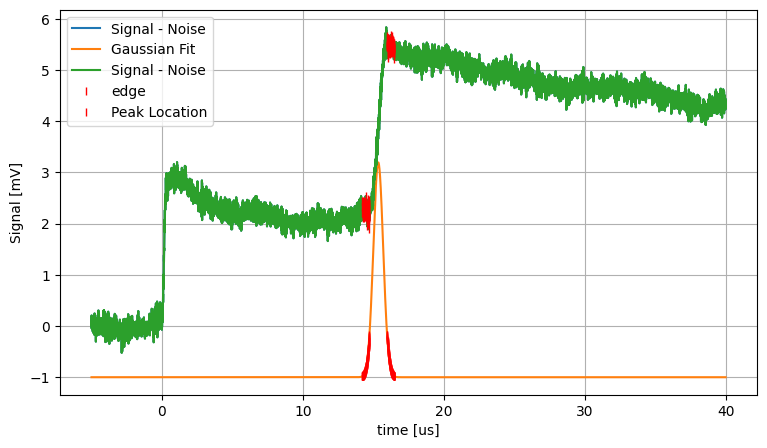

In [ ]:
run_number=Run_oldtonew(515)
waveform = Get_Waveform_from_session(run_number)
old_rn = Run_newtoold(run_number)
print("Old Run Number",old_rn)
print("New Run Number",run_number)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(GetBGRun(old_rn))
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)



WF_dict=Analyze_Anode(waveform,background_waveform,stepcounts=[100],debug=2,plot=2)



In [ ]:
WF_dict

{'anode': array([24.01678 , 24.061499, 24.1584  , ..., 28.05339 , 28.105469,
        28.172379], dtype=float32),
 'cathode': array([0.03923919, 0.03898475, 0.03906728, ..., 0.0154216 , 0.01509239,
        0.01490553], dtype=float32),
 'time': array([-5.002, -4.998, -4.994, ..., 44.99 , 44.994, 44.998], dtype=float32),
 'trigger': array([ 0.        , -0.03952387,  0.        , ..., -0.07920153,
         0.        , -0.03952387], dtype=float32),
 'uv': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'norm': {'anode': array([1.2817383e-03, 4.5999527e-02, 1.4290047e-01, ..., 4.0378914e+00,
         4.0899696e+00, 4.1568794e+00], dtype=float32),
  'anode-bg': array([-0.5739994 , -0.47598076, -0.45311928, ...,  0.01545143,
          0.03017998,  0.18146133], dtype=float32)},
 'denoised': {'anode': array([0.06441884, 0.10920914, 0.20618159, ..., 4.091471  , 4.143701  ,
         4.210762  ], dtype=float32),
  'anode-noise': array([-0.06313711, -0.06320962, -0.06328111, ..., -0.05357988,
 

Old Run Number 517
Background Run Number 716
::Anode Background Analysis::
Background Run Number 716
Time Resolution 0.004000187


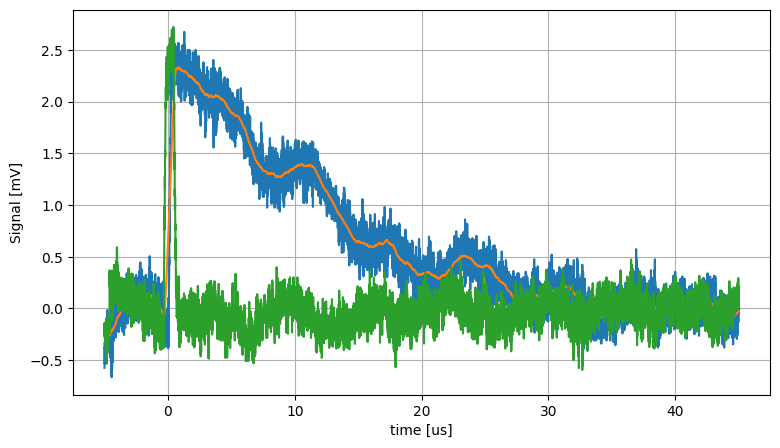

In [ ]:

old_bg = 517
print("Old Run Number",old_bg)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(old_bg)
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)

stepcount=200
diffsize=5

#def Anode_BackGround_cleanup(background_waveform,stepcounts=[100],debug=0,plot=False,savefig=True):
if 1:
    """
    Anode_BackGround_cleanup(background_waveform,stepcounts=[100],debug=0,plot=False,savefig=True) -> dict
    This function takes a background waveform and returns a dictionary of the waveforms from the session file."""
    global blankBG_DF
    if debug>=1:
        print("::Anode Background Analysis::")
        print("Background Run Number",bgnum)
    
    AnalysisResults={}

    last_index= np.min([len(background_waveform["time"]),len(background_waveform["anode"])])
    
    background_waveform["time"] = background_waveform["time"][:last_index]
    background_waveform["anode"] = background_waveform["anode"][:last_index]

    
    background_waveform["time"] = background_waveform["time"]/1e3 #convert to us

    background_waveform["anode"] = background_waveform["anode"]*1e3 #convert to mv

    time_resolution = background_waveform["time"][1] - background_waveform["time"][0]
    print("Time Resolution",time_resolution)
    #Find the average anode for the first 5 us and subtract to normalize. 
    anode_normalize = background_waveform["anode"][:int(5/time_resolution)].mean()
    background_waveform["norm"] = {}
    background_waveform["norm"]["anode"] = background_waveform["anode"] - anode_normalize
    background_waveform["norm"]["anode-smoothed"] = np.convolve(background_waveform["norm"]["anode"],  
    np.ones(stepcount)/(stepcount),mode="same")  
    background_waveform["norm"]["anode-derivative"] = np.gradient(background_waveform["norm"]["anode-smoothed"])


    edge_slice=slice(0,int(55/time_resolution))

    der_norm_for_plt = np.max(background_waveform["norm"]["anode"])/np.max(background_waveform["norm"]["anode-derivative"])

    if plot:
        fig_anode, ax_anode = plt.subplots(figsize=(9,5))
        ax_anode.grid()
        ax_anode.set_xlabel("time [us]")
        ax_anode.set_ylabel("Signal [mV]")
        ax_anode.errorbar(x=background_waveform["time"][edge_slice],y=background_waveform["norm"]["anode"][edge_slice], label="Normalized Signal")
        ax_anode.errorbar(x=background_waveform["time"][edge_slice],y=background_waveform["norm"]["anode-smoothed"][edge_slice], label="Smoothed Signal")
        ax_anode.errorbar(x=background_waveform["time"][edge_slice],y=background_waveform["norm"]["anode-derivative"][edge_slice]*der_norm_for_plt, label="Derivative Signal")






In [ ]:
Get_Waveform_from_session(bgnum)

{'anode': array([0.02843287, 0.02810838, 0.02850691, ..., 0.02951031, 0.0297612 ,
        0.03004123], dtype=float32),
 'cathode': array([0.03869536, 0.0399254 , 0.04017699, ..., 0.00508287, 0.00598738,
        0.00647588], dtype=float32),
 'time': array([-5001.333, -4997.333, -4993.333, ..., 44994.664, 44998.664,
        45002.664], dtype=float32),
 'trigger': array([ 0.        , -0.03952387,  0.        , ...,  0.        ,
         0.        ,  0.03952387], dtype=float32),
 'uv': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}

Old Run Number 600
Background Run Number 805
::Anode Background Analysis::
Background Run Number 805


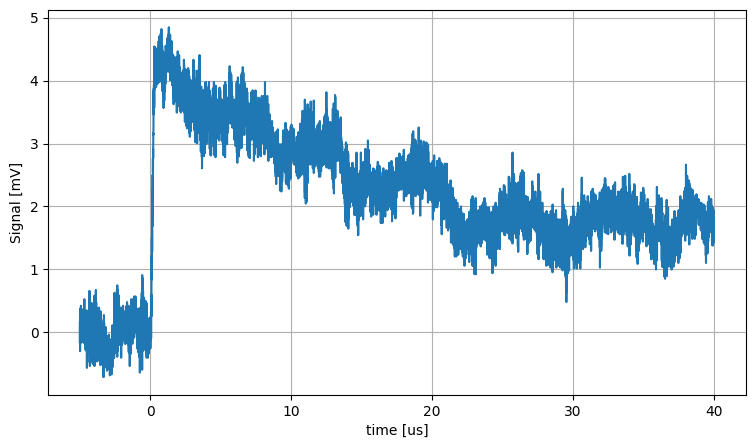

In [ ]:
run_number=Run_oldtonew(600)
waveform = Get_Waveform_from_session(run_number)
old_rn = Run_newtoold(run_number)
print("Old Run Number",old_rn)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(GetBGRun(old_rn))
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)




clean_bg = Anode_BackGround_cleanup(background_waveform,stepcounts=[100],debug=1,plot=True)

In [ ]:
WF_dict

{'anode': array([29.54013, 29.15438, 29.49889, ..., 46.34763, 46.42047, 46.27435],
       dtype=float32),
 'cathode': array([0.04000092, 0.03944559, 0.03891153, ..., 0.0097899 , 0.01008363,
        0.00965411], dtype=float32),
 'time': array([-5.002, -4.998, -4.994, ..., 44.994, 44.998, 45.002], dtype=float32),
 'trigger': array([ 0.        , -0.03952387,  0.        , ..., -0.07920153,
         0.        , -0.03952387], dtype=float32),
 'uv': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'norm': {'anode': array([ 0.08182526, -0.30392456,  0.04058456, ..., 16.889324  ,
         16.962166  , 16.816044  ], dtype=float32),
  'anode-bg': array([ 0.15594673, -0.16854286,  0.22998619, ...,  1.2333851 ,
          1.4842758 ,  1.764307  ], dtype=float32)},
 'denoised': {'anode': array([ 0.28643858, -0.09927407,  0.24526893, ..., 17.090855  ,
         17.163841  , 17.017862  ], dtype=float32),
  'anode-noise': array([-0.20461334, -0.20465049, -0.20468436, ..., -0.20152994,
         -0.20

In [ ]:
## analysis file name - session_date-analysis_verision.h5
## example file name - 001_230202_analysis_01.h5



Old Run Number 515
Background Run Number 716
::Anode Analysis::
Run Number 714
Background Run Number 716
Analysis File Name \\172.24.54.234\\NAS-Lab28\\Data\\analysis_trial\\029_241213_analysis_01.h5
Creating Analysis File or appending old file
analyzed results anode-time-delay
analyzed results anode-time-sigma
analyzed results anode-amp
analyzed results anode-amp-err


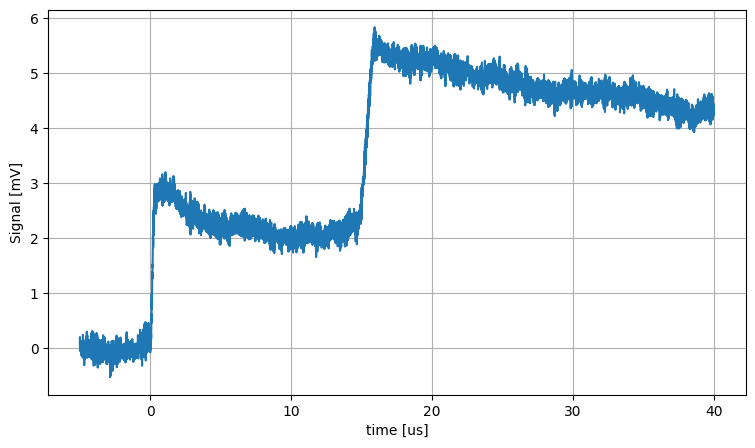

In [ ]:
run_number=714
RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]

waveform_temp = Get_Waveform_from_session(run_number)
old_rn = Run_newtoold(run_number)
print("Old Run Number",old_rn)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(GetBGRun(old_rn))
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)

renew_flag = True

waveform=Analyze_Anode(waveform_temp,background_waveform,debug=1,plot=False)


analysis_file_name = f"{env_session_file_location}\\\\analysis_trial\\\{RunInfo['session']:03}_{RunInfo['date']}_analysis_01.h5"

print("Analysis File Name",analysis_file_name)

with h5py.File(analysis_file_name, 'a') as analysis_h5:

    print("Creating Analysis File or appending old file")
    if "run" not in analysis_h5.keys():
        analysis_h5.create_group("run")
    
    if str(run_number) not in analysis_h5["run"].keys():
        analysis_h5.create_group(f"run/{run_number}")
    # add raw and time
    raw_keys = ["time","trigger","uv","anode","cathode"]
    for key in raw_keys:
        if key not in analysis_h5["run"][str(run_number)].keys():
            analysis_h5["run"][str(run_number)].create_dataset(key, data=waveform_temp[key])

    for analysis_key in ["norm","denoised","subtracted","analyzed"]:
        if analysis_key not in analysis_h5["run"][str(run_number)].keys():
            analysis_h5.create_group(f"run/{run_number}/{analysis_key}")
        else:
            if renew_flag:
                del analysis_h5["run"][str(run_number)][analysis_key]
                analysis_h5.create_group(f"run/{run_number}/{analysis_key}")

        
        if analysis_key in waveform.keys():
            for key in waveform[analysis_key].keys():

                if key not in analysis_h5["run"][str(run_number)][analysis_key].keys():

                    if key == "results":
                        analysis_h5["run"][str(run_number)][analysis_key].create_group(key)
                        for result_key in waveform[analysis_key][key].keys():
                            if result_key not in analysis_h5["run"][str(run_number)][analysis_key][key].keys():
                                print(analysis_key, key, result_key)
                                analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])
                            else:
                                if renew_flag:
                                    del analysis_h5["run"][str(run_number)][analysis_key][key][result_key]
                                    analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])

                    
                    else:
                        analysis_h5["run"][str(run_number)][analysis_key].create_dataset(key, data=waveform[analysis_key][key])
                else:
                    if renew_flag:
                        if key == "results":
                            del analysis_h5["run"][str(run_number)][analysis_key][key]
                            analysis_h5["run"][str(run_number)][analysis_key].create_group(key)
                            for result_key in waveform[analysis_key][key].keys():
                                if result_key not in analysis_h5["run"][str(run_number)][analysis_key][key].keys():
                                    print(analysis_key, key, result_key)
                                    analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])
                                else:
                                    if renew_flag:
                                        del analysis_h5["run"][str(run_number)][analysis_key][key][result_key]
                                        analysis_h5["run"][str(run_number)][analysis_key][key].create_dataset(result_key, data=waveform[analysis_key][key][result_key])


                        del analysis_h5["run"][str(run_number)][analysis_key][key]
                        analysis_h5["run"][str(run_number)][analysis_key].create_dataset(key, data=waveform[analysis_key][key])




    # Save time, trigger, and UV data to the analysis file
    # analysis_h5["run"][str(run_number)].create_dataset("time", data=waveform["time"])
    # analysis_h5["run"][str(run_number)].create_dataset("trigger", data=waveform["trigger"])
    # analysis_h5["run"][str(run_number)].create_dataset("uv", data=waveform["uv"])

    



In [ ]:
def Analyze_Cathode(waveform,background_waveform, stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True):
    """
    Analyze_Cathode(waveform,background_waveform, stepcounts=[100], diffsizes=[100],debug=0,plot=False,savefig=True) -> dict
    This function takes a waveform and background waveform and returns a dictionary of the waveforms from the session file."""

    AnalysisResults={}

    last_index= np.min([len(waveform["time"]),len(waveform["cathode"])])
    
    waveform["time"] = waveform["time"][:last_index]
    waveform["cathode"] = waveform["cathode"][:last_index]
    #background_waveform["time"] = background_waveform["time"][:last_index]
    #background_waveform["cathode"] = background_waveform["cathode"][:last_index]
    
    waveform["time"] = waveform["time"]/1e3 #convert to us
    #background_waveform["cathode"] = background_waveform["cathode"]*1e3 #convert to mv
    waveform["cathode"] = waveform["cathode"]*1e3 #convert to mv

    time_resolution = waveform["time"][1] - waveform["time"][0]
    #Find the average anode for the first 5 us and subtract to normalize. 
    cathode_normalize = waveform["cathode"][:int(5/time_resolution)].mean()

    waveform["norm"] = {}
    waveform["denoised"] = {}
    #waveform["subtracted"] = {}
    waveform["analyzed"]={}
    
    #Find the average anode for the first 5 us and subtract to normalize.   
    waveform["norm"]["cathode"] = waveform["cathode"] - cathode_normalize
    #waveform["norm"]["cathode-bg"] = background_waveform["cathode"] - background_waveform["cathode"][:int(5/time_resolution)].mean()
    
    if plot:
        fig_cathode, ax_cathode = plt.subplots(figsize=(9,5))
        ax_cathode.grid()
        ax_cathode.set_xlabel("time [us]")
        ax_cathode.set_ylabel("Signal [mV]")
        ax_cathode.errorbar(x=waveform["time"],y=waveform["norm"]["cathode"], label="Normalized Signal")
        #ax_cathode.errorbar(x=background_waveform["time"],y=background_waveform["norm"]["cathode-bg"], label="Back Ground")

Old Run Number 515
Background Run Number 716


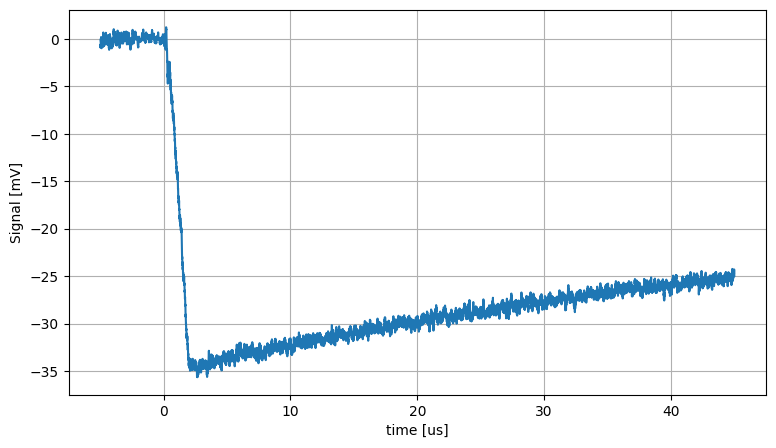

In [ ]:
run_number=714
RunInfo = RunDatabase.query(f'run == {run_number}').iloc[0]

waveform_temp = Get_Waveform_from_session(run_number)
old_rn = Run_newtoold(run_number)
print("Old Run Number",old_rn)
bgnum=0
if old_rn > -1:    
    bgnum = Run_oldtonew(GetBGRun(old_rn))
    background_waveform = Get_Waveform_from_session(bgnum)
else:
    background_waveform = blankBG_DF
print("Background Run Number",bgnum)

renew_flag = True

waveform=Analyze_Cathode(waveform_temp,background_waveform,debug=1,plot=True)

In [ ]:
Get_Waveform_from_session(580)


{'anode': array([0.02666183, 0.02664507, 0.02674159, ..., 0.02994496, 0.02997418,
        0.0297816 ], dtype=float32),
 'cathode': array([0.05593002, 0.0559302 , 0.05607319, ..., 0.00860732, 0.00859894,
        0.00838898], dtype=float32),
 'time': array([-10004., -10000.,  -9996., ...,  39988.,  39992.,  39996.],
       dtype=float32),
 'trigger': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'uv': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}

In [ ]:
session_files = glob.glob(env_session_file_location + "\\*.h5")

for session_file in session_files:
    # Open the HDF5 file
    with h5py.File(session_file, 'r') as f:
        # Check if 'data' exists in the file
        subdir = f['run']
        for runnumber in subdir.keys():
            channels=subdir[runnumber].keys()
            waveform_data={}
            for channel in channels:
                waveform_data[channel] = subdir[runnumber][channel]
                print(subdir[runnumber][channel])

                print(subdir[runnumber][channel])
                print(waveform_data)
            break


    break


<HDF5 dataset "anode": shape (12501,), type "<f4">
<HDF5 dataset "anode": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">}
<HDF5 dataset "cathode": shape (12501,), type "<f4">
<HDF5 dataset "cathode": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">, 'cathode': <HDF5 dataset "cathode": shape (12501,), type "<f4">}
<HDF5 dataset "time": shape (12501,), type "<f4">
<HDF5 dataset "time": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">, 'cathode': <HDF5 dataset "cathode": shape (12501,), type "<f4">, 'time': <HDF5 dataset "time": shape (12501,), type "<f4">}
<HDF5 dataset "trigger": shape (12501,), type "<f4">
<HDF5 dataset "trigger": shape (12501,), type "<f4">
{'anode': <HDF5 dataset "anode": shape (12501,), type "<f4">, 'cathode': <HDF5 dataset "cathode": shape (12501,), type "<f4">, 'time': <HDF5 dataset "time": shape (12501,), type "<f4">, 'trigger': <HDF5 dataset 

## Laser power analysis - calibration for laser settings to injected power


In [ ]:
runnumber = 500
debug = 10

#def MeasureLaserpower(runnumber=0, debug=0):
if 1==1:

    if debug >=10:
        print(f"Laser power analysis for Run number: {runnumber}")
    Runinfo = RunDatabase.query(f'run == {runnumber}').iloc[0]
    

    
